In [3]:
import requests
import yaml
from bs4 import BeautifulSoup
import json
from concurrent.futures import ThreadPoolExecutor

with open('./config/config.yml', 'r') as f:
    config = yaml.safe_load(f)
    
def getData(urlchotot):
    response = requests.get(url=urlchotot)
    soup = BeautifulSoup(response.text, 'html.parser')
    all_results = soup.find_all('div', attrs={'tabindex':"0"})
    for result in all_results:
        data = {}
        # data["name"] = result.find('h3',class_="adonovt").text
        # data["year"] = result.find('span', class_='c1u6gyxh').text
        # data["price"] = result.find('span', class_='bfe6oav').text
        newRequest = requests.get("https://xe.chotot.com"+result.find('a',attrs={'itemprop':'item'}).get('src'))
        newSoup = BeautifulSoup(newRequest.text, 'html.parser')
        print(1)
        data['image'] = newSoup.findAll('img', attrs={'sizes':'100vw'})[1].get('srcset')
        # data["description"] = newSoup.find('p', attrs={'itemprop':'description'}).text
        # data["urlcar"] = "https://xe.chotot.com"+result.find('a',attrs={'itemprop':'item'}).get('href')
        print(json.dumps(data, ensure_ascii=False, indent=2))

def main():
    urlchotot = config['url']['urlchotot']
    listUrl = [urlchotot.format(i) for i in range(1, 5)]

    # with ThreadPoolExecutor(max_workers=10) as executor:
    #     executor.map(getData, listUrl)

    for url in listUrl:
        getData(url)

if __name__ == '__main__':
    main()


TypeError: can only concatenate str (not "NoneType") to str

In [ ]:
from Utils.postgres_tool import PostgresTool
import yaml
with open('./config/config.yml', 'r') as f:
    config = yaml.safe_load(f)

db_params = config['database']
# import psycopg2
# try:
#     connection = psycopg2.connect(**db_params)
#     cursor = connection.cursor()
    
#     # Execute a simple query
#     cursor.execute("SELECT version();")
#     record = cursor.fetchone()
#     print("You are connected to - ", record, "\n")
    
#     # Close the cursor and connection
#     cursor.close()
#     connection.close()
# except Exception as error:
#     print("Error while connecting to PostgreSQL", error)
conn = PostgresTool(**db_params)
conn.get_all_table()

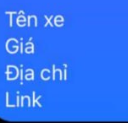

In [4]:
import requests
import yaml
from bs4 import BeautifulSoup
import json
import time
import redis
from messageTelegram.app import sendBot
import asyncio
import nest_asyncio

nest_asyncio.apply()

with open('./config/config.yml', 'r') as f:
    config = yaml.safe_load(f)

redis_sv = config['redis_sv']
print(redis_sv)
redis_client = redis.Redis(**redis_sv)

def getData(urlchotot):
    response = requests.get(url=urlchotot)
    soup = BeautifulSoup(response.text, 'html.parser')
    all_results = soup.find_all('div', attrs={'tabindex':"0"})
    redis_set_key = "carchotot"

    for result in all_results:
        newRequest = requests.get("https://xe.chotot.com"+result.find('a',attrs={'itemprop':'item'}).get('href'))
        newSoup = BeautifulSoup(newRequest.text, 'html.parser')
        data = {}
        data["name"] = newSoup.find('h1').text
        data["price"] = newSoup.find('b', class_='p26z2wb').text
        data["location"] = newSoup.find('span', class_ = "bwq0cbs flex-1").text
        data["urlcar"] = "https://xe.chotot.com"+result.find('a',attrs={'itemprop':'item'}).get('href')
        data['image'] = "https://xe.chotot.com"+newSoup.findAll('img', attrs={'sizes':'100vw'})[1].get('src')
        redis_key = f"{data}" 
        exists = redis_client.sismember(redis_set_key, str(data))
        if not exists:
            redis_client.sadd(redis_set_key, str(data))
            redis_client.expire(redis_set_key, 60*60*24)
            redis_client.setex(redis_key, 60*60*24, str(data))

            data = {k: (v if v != "None" else None) for k, v in data.items()}
            print(json.dumps(data, ensure_ascii=False, indent=2)) # debug
            # send data telegram message
            asyncio.run(sendBot(data))
        else:
            pass

def main():
    urlchotot = config['url']['urlchotot']
    listUrl = [urlchotot.format(i) for i in range(1, 10)]
    for url in listUrl: 
        getData(url)

if __name__ == '__main__':
    while True:
        main()
        time.sleep(30*60) # 30 p
        # time.sleep(2)


{'host': 'localhost', 'port': 6377, 'db': 0}
{
  "name": "Hyundai SantaFe 2021 Full Xăng Đi 55,000km Màu Đen",
  "price": "875.000.000 đ",
  "location": "Phường Tân Phong, Quận 7, Tp Hồ Chí Minh",
  "urlcar": "https://xe.chotot.com/mua-ban-oto-quan-7-tp-ho-chi-minh/118495855.htm#px=SR-stickyad-[PO-1][PL-top]",
  "image": "https://xe.chotot.com/_next/image?url=https%3A%2F%2Fcdn.chotot.com%2F13bCWO1rnYEQ24Z12bEme5w1tig5T0szpzUfLmLDn4k%2Fpreset%3Aview%2Fplain%2F87f8f9ec8b7c38905fb764d4b5473fe5-2890790255025597827.jpg&w=3840&q=100"
}
{
  "name": "Fortuner 2022 Máy Dầu Tự Động Odo 29,000km Zin Đẹp",
  "price": "995.000.000 đ",
  "location": "Phường Tân Phong, Quận 7, Tp Hồ Chí Minh",
  "urlcar": "https://xe.chotot.com/mua-ban-oto-quan-7-tp-ho-chi-minh/118506037.htm#px=SR-stickyad-[PO-2][PL-top]",
  "image": "https://xe.chotot.com/_next/image?url=https%3A%2F%2Fcdn.chotot.com%2FwRGKoIImCXkbmkHFVcJev8z33Xtck-iM0h63EcTaE8s%2Fpreset%3Aview%2Fplain%2F484e385e0e1673571540ee485f9c1d8a-2890868056276

d:\ETL-out\.venv\Lib\site-packages\bs4\builder\__init__.py:311: RuntimeWarning: coroutine 'sendBot' was never awaited
  universal = self.cdata_list_attributes.get('*', [])


{
  "name": "Hyundai Accent 2018 1.4 MT - 450000 km",
  "price": "300.000.000 đ",
  "location": "Phường Trường An, Thành phố Huế, Thừa Thiên Huế",
  "urlcar": "https://xe.chotot.com/mua-ban-oto-thanh-pho-hue-thua-thien-hue/118569236.htm",
  "image": "https://xe.chotot.com/_next/image?url=https%3A%2F%2Fcdn.chotot.com%2FL5pDyicsRekNk5DCOcPbeZooPBRzcOyHT2ror-t61Ek%2Fpreset%3Aview%2Fplain%2Fe04a6545089c74b84d1e6429d8c8dc1c-2891190764005378317.jpg&w=3840&q=100"
}
{
  "name": "Mazda CX 5 Deluxe Sx 2023 moden 2024",
  "price": "765.000.000 đ",
  "location": "Phường Ngọc Lâm, Quận Long Biên, Hà Nội",
  "urlcar": "https://xe.chotot.com/mua-ban-oto-quan-long-bien-ha-noi/118540510.htm",
  "image": "https://xe.chotot.com/_next/image?url=https%3A%2F%2Fcdn.chotot.com%2F0paM_JwqmbP8_gJ3uwwQ_5UIK-lCqYg-JQP-jIfKElU%2Fpreset%3Aview%2Fplain%2F9a6c65b908d01cca97e8baeadd475d6f-2891037308004627167.jpg&w=3840&q=100"
}
{
  "name": "Honda BR-V 2024 - KM 50% Thuế Tặng Kèm Phụ Kiện",
  "price": "661.000.000 đ",


KeyboardInterrupt: 

In [7]:
from messageTelegram.app import potsMessage
data = {
    "name": "anacode",
    "year": "2005",
    "price": " 97 Triệu ",
    "description": " *Xe nhập khẩu, màu đen, máy dầu 2.5 L, số tay, 6 chỗ ... Hyundai Starex 2005 máy dầu 6 chỗ 800kg xe đẹp máy êm ko khói đhoa cực mát xe cc miễn TG ",
    "urlcar": "https://bonbanh.com/xe-hyundai-starex-van-2.5-mt-2005-5571723",
    "location": "Phường Hố Nai, Thành phố Biên Hòa, Đồng Nai"
}

potsMessage(data)


<coroutine object potsMessage at 0x00000255C140F640>

In [2]:
asyncio.run(potsMessage(data))


C:\Users\obito\AppData\Local\Temp\ipykernel_4860\693254464.py:26: RuntimeWarning: coroutine 'Bot.send_message' was never awaited
  bot.send_message(
